In [1]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
π = pi

In [2]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `res/car-trainer-k.png` available as well):
![car-trailer](res/car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [3]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([]); self.ax.set_yticks([])
            self.ax.axhline(); self.ax.axvline()

        self.reset()
    
    def reset(self, ϕ=0):
        self.ϕ = ϕ  # car initial steering angle
        
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = (random() * .75 + 0.25) * self.box[1]
        self.y = (random() - 0.5) * (self.box[3] - self.box[2])
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self, clr=True):
        if not self.display: return
        if self.patches and clr: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

In [4]:
truck = Truck(display=False)

In [5]:
ϕ = deg2rad(35)  # positive left, negative right
truck.step(ϕ)
truck.draw()

In [6]:
truck.reset()

In [7]:
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm

In [8]:
# Build expert data set

episodes = 10
inputs = list()
outputs = list()
truck = Truck(); episodes = 10_000  # uncooment for creating the data set

for episode in tqdm(range(episodes)):
    
    truck.reset()
    
    while truck.valid():
        initial_state = truck.state()
        ϕ = (random() - 0.5) * π / 2
        inputs.append((ϕ, *initial_state))
        outputs.append(truck.step(ϕ))
        truck.draw()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 310.25it/s]


In [9]:
len(inputs), len(outputs)

(596399, 596399)

In [10]:
state_size = 6
steering_size = 1
hidden_units_e = 45

emulator = nn.Sequential(
    nn.Linear(steering_size + state_size, hidden_units_e),
    nn.ReLU(),
    nn.Linear(hidden_units_e, state_size)
)

optimiser_e = SGD(emulator.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [11]:
tensor_inputs = torch.Tensor(inputs)
tensor_outputs = torch.Tensor(outputs)

In [12]:
mean = tensor_inputs.mean(0)
std = tensor_inputs.std(0)
tensor_inputs = (tensor_inputs - mean) / std
tensor_outputs = (tensor_outputs - mean[1:]) / std[1:]

In [13]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.8)
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_outputs = tensor_outputs[:test_size]
test_inputs = tensor_inputs[test_size:]
test_outputs = tensor_outputs[test_size:]

596399 477119


In [14]:
len(train_inputs)

477119

In [15]:
# Emulator training
cnt = 0
for i in torch.randperm(len(train_inputs)):
    ϕ_state = train_inputs[i]
    next_state_prediction = emulator(ϕ_state)
    
    next_state = train_outputs[i]
    loss = criterion(next_state_prediction, next_state)
    
    optimiser_e.zero_grad()
    loss.backward()
    optimiser_e.step()
    
    if cnt == 0 or (cnt + 1) % 10000 == 0:
        print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
    cnt += 1

   1 / 477119, 0.2271876931
10000 / 477119, 0.0071430625
20000 / 477119, 0.0030008652
30000 / 477119, 0.0008347177
40000 / 477119, 0.0020963782
50000 / 477119, 0.0013038847
60000 / 477119, 0.0011208849
70000 / 477119, 0.0002758813
80000 / 477119, 0.0006922329
90000 / 477119, 0.0005252823
100000 / 477119, 0.0004230983
110000 / 477119, 0.0005469278
120000 / 477119, 0.0000862364
130000 / 477119, 0.0001345091
140000 / 477119, 0.0007230619
150000 / 477119, 0.0001785361
160000 / 477119, 0.0007830507
170000 / 477119, 0.0005586377
180000 / 477119, 0.0002954097
190000 / 477119, 0.0001287403
200000 / 477119, 0.0002669602
210000 / 477119, 0.0004215323
220000 / 477119, 0.0001005990
230000 / 477119, 0.0003307245
240000 / 477119, 0.0002180831
250000 / 477119, 0.0000768793
260000 / 477119, 0.0003662281
270000 / 477119, 0.0000126233
280000 / 477119, 0.0001566038
290000 / 477119, 0.0005040736
300000 / 477119, 0.0003978141
310000 / 477119, 0.0001590988
320000 / 477119, 0.0001360818
330000 / 477119, 0.00

In [16]:
# Test
total_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(ϕ_state)

        next_state = test_outputs[idx]
        total_loss += criterion(next_state_prediction, next_state).item()

ave_test_loss = total_loss/test_size
print(f'Test loss: {ave_test_loss:.10f}')

Test loss: 0.0000282477


In [17]:
# Here you need to insert the code for training the controller
# by using the emulator for backpropagation

def dis_to_dock(state):
    x_t = state[3] * std[4] + mean[4]
    y_t = state[4] * std[5] + mean[5]
    theta1 = state[5] * std[6] + mean[6]
    theta1 = theta1 %(2*π)

    return x_t*x_t + y_t*y_t + theta1*theta1*3

def unnorm(state):
    x_t = state[3] * std[4] + mean[4]
    y_t = state[4] * std[5] + mean[5]
    theta1 = state[5] * std[6] + mean[6]
    theta1 = theta1 %(2*π)
    return x_t, y_t, theta1

def reset_truck(truck, ϕ=0, difficulty = 0.3):
    truck.ϕ = ϕ  # car initial steering angle
    truck.θ0 = random() * 2 * π * difficulty  # 0 <= ϑ₀ < 2π
    truck.θ1 = (random() - 0.5) * π / 2 * difficulty + truck.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
    truck.x = (random() * .75 + 0.25) * truck.box[1] * difficulty * 2
    truck.y = (random() - 0.5) * (truck.box[3] - truck.box[2]) * difficulty

    # If poorly initialise, then re-initialise
    if not truck.valid():
        reset_truck(truck, ϕ, difficulty)

#     # Draw, if display is True
#     if truck.display: truck.draw()

In [50]:
state_size = 6
steering_size = 1
hidden_units_c = 45

controller = nn.Sequential(
    nn.Linear(state_size, hidden_units_c),
    nn.ReLU(),
    nn.Linear(hidden_units_c, steering_size),
)
controller.requires_grad = True

In [51]:
# 1.Freeze the weights of the emulator network
emulator.requires_grad = False
optimizer_c = torch.optim.Adam(filter(lambda p: p.requires_grad, controller.parameters()), lr=5e-3, weight_decay=1e-2)
# optimizer_c = SGD(filter(lambda p: p.requires_grad, controller.parameters()), lr=0.005, weight_decay=1e-2)
criterion = nn.MSELoss()

In [52]:
# ONE ITERATION START

In [53]:
# 2.Place the truck at a random position wrt to the current difficulty
truck.reset()

In [54]:
# ϕ = deg2rad(-35)  # positive left, negative right
# truck.step(ϕ)    
x, y, W, L, d, s, θ0, θ1, ϕ = truck._get_atributes()
# print(θ0 - θ1)
# print(abs(θ0 - θ1) * 180 / π)
# print(abs(θ0 - θ1) * 180 / π>90)

# jackinfe data generate
state_train = []
fai_train = []
jack_times = 0
save_car_base_deg = 10
save_car_random_deg = 50
save_car_trigger = 1.45
random_drive_data_rate = 0.1
random_sample = 0
for j in range(1000):
    truck.reset()
    for i in range(1000):
        if (θ0 - θ1) > save_car_trigger:
            fai_target = deg2rad(np.random.rand()*save_car_random_deg + save_car_base_deg)
            state_train.append(truck.state())
            fai_train.append(fai_target)
            truck.step(fai_target)
        elif (θ0 - θ1) < (-1 * save_car_trigger):
            fai_target = deg2rad(-1*save_car_random_deg*np.random.rand() - save_car_base_deg)
            state_train.append(truck.state())
            fai_train.append(fai_target)
            truck.step(fai_target)
        else:
            fai_target = (np.random.rand()-0.5) * 1.5
            if np.random.rand() < random_drive_data_rate:
                state_train.append(truck.state())
                fai_train.append(fai_target)
                random_sample += 1
            truck.step(fai_target)
        x, y, W, L, d, s, θ0, θ1, ϕ = truck._get_atributes()
        if not truck.valid():
#             print(θ0 - θ1)
#             print(abs(θ0 - θ1) * 180 / π>90)
            if abs(θ0 - θ1) * 180 / π>90:
                jack_times += 1
            break
print(len(fai_train), random_sample)
print("hardcode jacknife rate =", jack_times / 1000)

177435 36330
hardcode jacknife rate = 0.002


In [65]:
# train controller wrt jacknife
optimizer_c.weight_decay = 3e-3
optimizer_c.lr = 5e-4
state_train = torch.Tensor(state_train)
state_train = (state_train - mean[1:]) / std[1:]
fai_train = torch.Tensor(fai_train)

loss_his = []
print(len(fai_train))

for i in torch.randperm(len(fai_train)):

    ϕ = controller(state_train[i]) 
#     ϕ = (ϕ - 0.5) * 2 # constrain ϕ to [-1, 1]
    loss = criterion(ϕ, fai_train[i])
    
    optimizer_c.zero_grad()
    loss.backward()
    loss_his.append(loss.item())
    optimizer_c.step()
    if len(loss_his) % 4000 == 0:
        print(len(loss_his), np.mean(loss_his[-1000:]), ϕ.item(), fai_train[i].item())
    

177435
4000 0.2053171209790856 0.20972000062465668 0.4770475924015045
8000 0.18614599704645093 -0.25118952989578247 -0.5618277788162231
12000 0.168311397869896 0.6833038330078125 0.6771700978279114
16000 0.1727359367791896 -0.3465939164161682 -0.2437262386083603
20000 0.18847801787184887 -0.13644856214523315 -0.15856336057186127
24000 0.15002086116965652 -0.21949532628059387 0.4965003728866577
28000 0.15372569021775206 -0.4271509647369385 -0.1560424119234085
32000 0.15937999483728837 0.4690101444721222 0.7007869482040405
36000 0.1571370022324179 0.4755144417285919 1.0230720043182373
40000 0.14777204777532454 -0.38566067814826965 -0.23881928622722626
44000 0.14410589213385697 -0.4832632541656494 -0.6973311901092529
48000 0.16080176785051198 0.45758748054504395 0.5552970767021179
52000 0.15799321340583528 -0.5814230442047119 -1.0349347591400146
56000 0.16022725603155988 -0.4143144488334656 -0.7888520956039429
60000 0.1574495356214816 0.014446049928665161 0.4862082302570343
64000 0.158533

In [66]:
# test controller wrt jacknife

jack_times = 0
result = []
for j in range(1000):
    truck.reset()
    for i in range(1000):
        tensor_state = torch.Tensor(truck.state()).view(1,6)
        tensor_state = (tensor_state - mean[1:]) / std[1:]
        ϕ = controller(tensor_state)
#         ϕ = (ϕ - 0.5) * 2

        truck.step(ϕ.detach().numpy())
        result.append(ϕ.detach().numpy())
        x, y, W, L, d, s, θ0, θ1, ϕ = truck._get_atributes()
#         if i == 200:
#             print("%.4f" % ϕ.item(), end=',')
        if not truck.valid():
#             print(θ0 - θ1)
#             print(abs(θ0 - θ1) * 180 / π>90)
            if abs(θ0 - θ1) * 180 / π>90:
                jack_times += 1
            break

print(np.mean(result), np.std(result))
print("jacknife rate =%.4f" % (jack_times / 1000))

-0.088071354 0.16770901
jacknife rate =0.2330


In [85]:
# 3 Foward pass
dummy_truck = Truck(display=False) #dummy truck for validation
optimizer_c.lr = 5e-3
optimizer_c.weight_decay = 1e-3
max_step = 500 # each init state, try this steps
max_trial = 10000 # how many init states
sampled_dis = 0 # take as training data when distance smaller than this
min_dis = 8 # stop condition
difficulty = 0.3
num_success = 0
VERBOSE = 0
success_samples = []
success_states_for_visual = []
is_succeed_last_turn = 0

for i in range(max_trial):
    if i % 1000 == 0:
        print("iter=%d" % i, "loss=%.2f" % loss.item(), "success rate =", num_success/(i+1))
    if num_success > 1000:
        break
    if VERBOSE:
        print("Start at", truck.state())
    reset_truck(truck, difficulty=difficulty)
    if not is_succeed_last_turn or is_succeed_last_turn > 0:
        initial_state = truck.state() # The true truck state

        
    tensor_state = torch.Tensor(initial_state)
    tensor_state = (tensor_state - mean[1:]) / std[1:]
    global_step = 0
    states = []
    states_for_visual = []
    dummy_truck.θ0 = (tensor_state[2]*std[3]+mean[3]).detach().numpy()
    dummy_truck.θ1 = (tensor_state[5]*std[6]+mean[6]).detach().numpy()
    dummy_truck.x = (tensor_state[0]*std[1]+mean[1]).detach().numpy()
    dummy_truck.y = (tensor_state[1]*std[2]+mean[2]).detach().numpy()
    if VERBOSE:
        print("Start in dis =", dis_to_dock(tensor_state).item(), "state =", tensor_state.data)
    while dummy_truck.valid() and global_step < max_step and dis_to_dock(tensor_state) > min_dis:   
        # 3.1 Calculate the next steering signal ui with the controller
        ϕ = controller(tensor_state) 
#         ϕ = (ϕ - 0.5) * 2 # constrain ϕ to [-1, 1]
        ϕ = (ϕ - mean[0]) / std[0]
        # 3.2 Use the emulator to c = alculate the next position
        ϕ_state = torch.cat((ϕ, tensor_state),0)
        tensor_state = emulator(ϕ_state)
        global_step += 1
        states.append(tensor_state)

        dummy_truck.θ0 = (tensor_state[2]*std[3]+mean[3]).detach().numpy()
        dummy_truck.θ1 = (tensor_state[5]*std[6]+mean[6]).detach().numpy()
        dummy_truck.x = (tensor_state[0]*std[1]+mean[1]).detach().numpy()
        dummy_truck.y = (tensor_state[1]*std[2]+mean[2]).detach().numpy()
        states_for_visual.append((ϕ_state*std+mean).detach().numpy()) 
        # 3.3 Repeat steps 1 and 2 until the truck is at the dock or a maximum number of steps $k$ were performed)
        
    if dis_to_dock(tensor_state) <= min_dis and global_step > 2:
        num_success += 1
        success_samples.append(initial_state)
        success_states_for_visual.append(states_for_visual)
        is_succeed_last_turn += 1
        print("Docked in dis = %.4f" % dis_to_dock(tensor_state).item(), "state =", tensor_state.data, "succ_num =", is_succeed_last_turn)
        

    elif not dummy_truck.valid():
        is_succeed_last_turn = 0
        if VERBOSE:
            print("Stucked in dis =", dis_to_dock(tensor_state).item(), "state =", tensor_state.data)
    elif global_step >= max_step:
        is_succeed_last_turn = 0
        if VERBOSE:
            print("Stopped in dis =", dis_to_dock(tensor_state).item(), "state =", tensor_state.data)
    else:
        is_succeed_last_turn = 0
        if VERBOSE:
            print("Too easy init state")
    # 4 Backward pass
    # 4.1 If the maximum number of steps was reached in step 3, do not perform backpropagation.

    if (global_step < max_step and global_step > 1 and dummy_truck.valid()) or (global_step > 1 and dis_to_dock(tensor_state) < sampled_dis): # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # 4.2 Calculate the sum squared error between the final truck position and the dock
        # 4.3 Calculate the derivative of the error wrt the truck state and use backpropagation through time (BPTT) to propagate the error through all emulators and controllers
        optimizer_c.zero_grad()
        z = torch.Tensor([0])
        x, y, t = unnorm(tensor_state)
        loss = criterion(x, z) + criterion(y, z) + criterion(t, z)
        loss.backward()
        optimizer_c.step()

#         print("Trained a step, loss=", loss.item())

    

iter=0 loss=7.78 success rate = 0.0
Docked in dis = 7.9058 state = tensor([-2.4866, -0.0250, -1.1472, -2.3131, -0.1897, -1.1296]) succ_num = 1
Docked in dis = 7.7893 state = tensor([-2.3979,  0.2604, -1.1373, -2.2890,  0.0645, -1.1735]) succ_num = 1
Docked in dis = 7.7726 state = tensor([-2.4086,  0.1783, -1.1926, -2.2795, -0.0533, -1.2000]) succ_num = 1
iter=1000 loss=6.67 success rate = 0.002997002997002997
Docked in dis = 7.5387 state = tensor([-2.4454,  0.1160, -1.1437, -2.2867, -0.0313, -1.1889]) succ_num = 1
Docked in dis = 7.9188 state = tensor([-2.3594,  0.2276, -1.2227, -2.2599, -0.0077, -1.2860]) succ_num = 1
Docked in dis = 7.7438 state = tensor([-2.3714,  0.3927, -1.1994, -2.2887,  0.2002, -1.3046]) succ_num = 1
iter=2000 loss=7.30 success rate = 0.0029985007496251873
Docked in dis = 7.5031 state = tensor([-2.3923,  0.1524, -1.2237, -2.2650,  0.0051, -1.3128]) succ_num = 1
Docked in dis = 7.6425 state = tensor([-2.3274,  0.3883, -1.2963, -2.2762,  0.1822, -1.4012]) succ_num

<IPython.core.display.Javascript object>


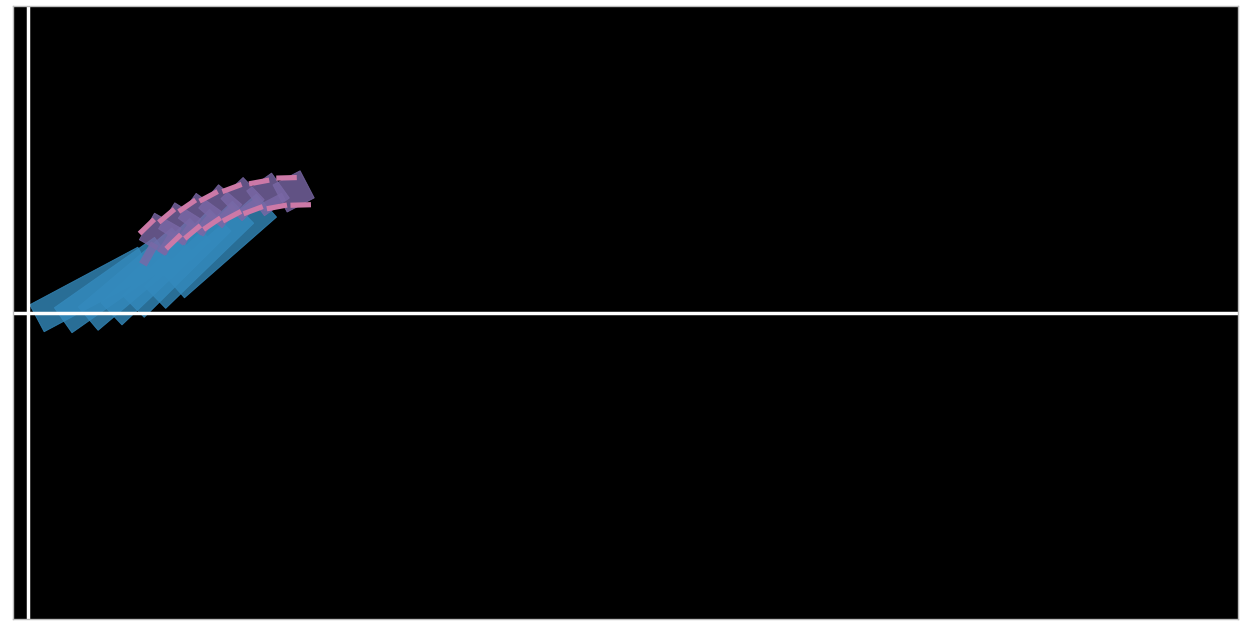

(12.538450348807736, 1.0890993633653006, 0.4716156647731202, 9.21075438383765, -1.1304590532396332, 0.5882302608218748)


In [80]:
truck2 = Truck(display=True)
reset_truck(truck2, difficulty=0.2)
truck2.clear()
truck2.draw()
print(truck2.state())

In [86]:
# draw result
import time
interval = 5
MODE = 1   # 0 see a fail sample.  1 see a success sample 
if not MODE:
    print("num of steps =", len(states_for_visual))
    truck2.clear()
    for i in range(0,len(states_for_visual),interval):
        x = states_for_visual[i]
        truck2.ϕ = x[0]
        truck2.x, truck2.y, truck2.θ0, truck2.θ1 = x[1], x[2], x[3], x[6]
        print("state:",x[1], x[2], x[3], x[6])
        truck2.draw(clr=False)
#         truck2._draw_car()
#         truck2._draw_trailer()
#         truck2.f.canvas.draw()
        time.sleep(0.15)
if MODE:
    for s in success_states_for_visual:
        if len(s) < 20:
            continue;
        print("num of steps =", len(s))
        truck2.clear()
        
        for i in range(0,len(s),interval):
            x = s[i]
            truck2.ϕ = x[0]
            truck2.x, truck2.y, truck2.θ0, truck2.θ1 = x[1], x[2], x[3], x[6]
            print("state:",x[1], x[2], x[3], x[6])
            truck2._draw_car()
            truck2._draw_trailer()
            truck2.f.canvas.draw()
            time.sleep(0.2)
        time.sleep(1)

num of steps = 31
state: 7.0782948 1.9459349 0.9897964 0.99790215
state: 6.324848 1.5200013 0.88917494 1.0327902
state: 5.5438366 1.185879 0.89452934 1.0477989
state: 4.811556 0.875648 0.9248774 1.0306759
state: 4.1347885 0.57462513 0.95017624 0.9782095
state: 3.4879208 0.28203183 0.96206665 0.8892126
state: 2.90757 0.020956583 0.9537065 0.77877426
num of steps = 33
state: 7.70615 3.2318032 0.61614275 0.8335669
state: 7.023102 2.9701772 0.65116596 0.8775084
state: 6.3344154 2.7069476 0.73213863 0.90240526
state: 5.6669064 2.4180048 0.8175945 0.90124035
state: 5.0546207 2.1034973 0.8831403 0.8745513
state: 4.463705 1.778212 0.93568516 0.82303333
state: 3.876543 1.4585483 0.9712448 0.7406759
num of steps = 26
state: 7.435154 2.2800176 0.73302984 0.7741642
state: 6.6324196 2.0577872 0.7097008 0.7905216
state: 5.8397007 1.82093 0.7430773 0.7925303
state: 5.048334 1.5559049 0.80159163 0.771508
state: 4.290457 1.2533624 0.8501668 0.7241218
state: 3.585474 0.968065 0.8645108 0.6295357
num of 

state: 4.9895 2.1984208 0.96640515 0.7115152
state: 4.313034 1.8781362 0.99007607 0.6331017
num of steps = 21
state: 7.2171 2.3472803 0.70895004 0.723598
state: 6.3648224 2.1326451 0.7365103 0.7369611
state: 5.508871 1.8875284 0.8067646 0.72409225
state: 4.711773 1.595051 0.8692987 0.6806383
state: 3.967039 1.273563 0.916486 0.6078043
num of steps = 24
state: 7.697191 1.2141304 0.96078944 0.71964574
state: 6.9182415 0.7004261 0.91515326 0.6343274
state: 6.1501007 0.21919729 0.87526727 0.56473017
state: 5.3623333 -0.19596168 0.8468375 0.49111223
state: 4.530052 -0.53421247 0.82991934 0.4022975
num of steps = 26
state: 7.635412 3.363988 0.53644085 0.5996635
state: 6.7973156 3.2016642 0.6643896 0.61988497
state: 5.9812145 2.9694924 0.78167963 0.6029949
state: 5.2423973 2.6763508 0.85778594 0.5516684
state: 4.543865 2.3533201 0.9075968 0.4697926
state: 3.8607063 2.006566 0.93632364 0.35759377
num of steps = 25
state: 7.670698 3.0148058 0.9866004 0.74245715
state: 6.837351 2.7075148 0.92944

KeyboardInterrupt: 

In [514]:
# check gradient
for name, parms in controller.named_parameters():
    print('-->name:', name, '-->grad_requirs:',parms.requires_grad, ' -->grad_value:',parms.grad)

-->name: 0.weight -->grad_requirs: True  -->grad_value: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 6.1856e-05,  1.5464e-05,  2.6066e-05,  2.7895e-05,  5.0631e-05,
          2.4874e-05],
        [ 4.5950e-05,  1.1487e-05,  1.9363e-05,  2.0722e-05,  3.7611e-05,
          1.8477e-05],
        [ 5.5989e-05,  1.3997e-05,  2.3593e-05,  2.5249e-05,  4.5828e-05,
          2.2514e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 3.5968e-05,  8.9921e-06,  1.5157e-05,  1.6221e-05,  2.9441e-05,
          1.4464e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+0